In [54]:
%pip install pandas numpy matplotlib seaborn scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [55]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from scipy.io.arff import MetaData, loadarff
from pandas import DataFrame, Series, crosstab
from numpy import ndarray
from numpy.random import shuffle
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import TransformerMixin
import seaborn as sns
import sys

EPSILON: float = sys.float_info.epsilon
NL='\n'
TAB='\t'

@pd.api.extensions.register_dataframe_accessor("custom")
class DescAccessor:
    def __init__(self, pandas_obj: DataFrame) -> None:
        self._df: DataFrame = pandas_obj

    def describe(self) -> DataFrame:
        df_describe: DataFrame = self._df.describe()
        df_describe.loc['missing'] = len(self._df) - df_describe.loc['count']
        df_feature_group_describe_index: list[str] = [*df_describe.index[0:1], 'missing', *df_describe.index[1:-1]]
        return df_describe.loc[df_feature_group_describe_index]

/tmp/ipykernel_41711/316953355.py:21: UserWarning: registration of accessor <class '__main__.DescAccessor'> under name 'custom' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  @pd.api.extensions.register_dataframe_accessor("custom")


# Récupération et traitement des données (cf. ml_eda)

In [56]:
# Chargement du jeu de données
data: ndarray
meta: MetaData
data, meta = loadarff('speeddating.arff')

original_df: DataFrame = DataFrame(data)
# Conversion des types des colonnes
for col in original_df.select_dtypes([object]):
    try:
        original_df[col] = original_df[col].astype(int)
    except:
        try:
            original_df[col] = original_df[col].astype(float)
        except:
            original_df[col] = original_df[col].astype(str)

# Correction des noms de colonnes
original_df.rename(
    columns={
        'sinsere_o': 'sincere_o',
        'intellicence_important': 'intelligence_important',
        'ambition': 'ambitious',
        'ambtition_important': 'ambitious_important',
        'ambition_partner': 'ambitious_partner',
        'ambitous_o': 'ambitious_o'
    },
    inplace=True
)

# Récupération des colonnes utiles
columns: list[str] = ['age', 'age_o', 'ambitious', 'ambitious_important', 'ambitious_o', 'ambitious_partner', 'art', 'attractive', 'attractive_important', 'attractive_o', 'attractive_partner', 'clubbing', 'concerts', 'd_age', 'decision', 'decision_o', 'dining', 'exercise', 'expected_happy_with_sd_people', 'expected_num_matches', 'funny', 'funny_important', 'funny_o', 'funny_partner', 'gaming', 'gender', 'guess_prob_liked', 'hiking', 'importance_same_race', 'importance_same_religion', 'intelligence', 'intelligence_important', 'intelligence_o', 'intelligence_partner', 'interests_correlate', 'like', 'match', 'met', 'movies', 'music', 'pref_o_ambitious', 'pref_o_attractive', 'pref_o_funny', 'pref_o_intelligence', 'pref_o_shared_interests', 'pref_o_sincere', 'race', 'race_o', 'reading', 'samerace', 'shared_interests_important', 'shared_interests_o', 'shared_interests_partner', 'shopping', 'sincere', 'sincere_important', 'sincere_o', 'sincere_partner', 'sports', 'theater', 'tv', 'tvsports', 'yoga' ]
df: DataFrame = original_df[columns].copy()

# Remplacement des catégories '?' par 'Other'
df.loc[df['race'] == '?', 'race'] = 'Other'
df.loc[df['race_o'] == '?', 'race_o'] = 'Other'

# Bornage des valeurs a 10 dans les activités 'gaming' et 'reading'
df.loc[df['gaming'] > 10, 'gaming'] = 10
df.loc[df['reading'] > 10, 'reading'] = 10

# Correction des valeurs d'ages
df.loc[df['age_o'].isna() & df['age'].notna(), 'd_age'] = float('nan')
df.loc[df['age_o'].notna() & df['age'].isna(), 'd_age'] = float('nan')
df.loc[df['age_o'].isna() & df['age'].isna(), 'd_age'] = float('nan')

mean_d_age: float = df['d_age'].describe()['mean']
df.loc[df['d_age'].isna(), 'd_age'] = mean_d_age

df.loc[df['age_o'].isna() & df['age'].notna(), 'age_o'] = df['age'] + df['d_age']
df.loc[df['age_o'].notna() & df['age'].isna(), 'age'] = df['age_o'] + df['d_age']
df.loc[df['age_o'].isna() & df['age'].isna(), ['age', 'age_o']] = [df['age'].describe()['mean'], df['age'].describe()['mean'] + mean_d_age]

## Gestion des données manquantes

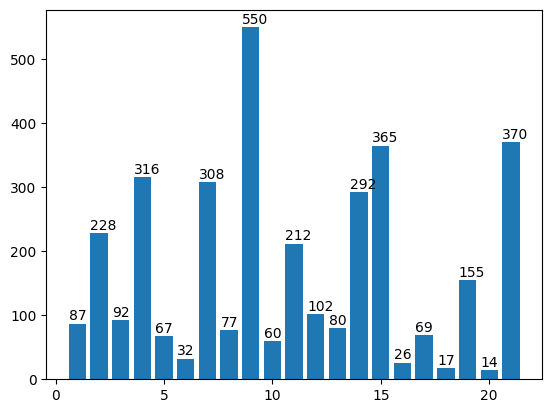

In [57]:
wave_df: DataFrame = original_df[original_df.columns.difference(['expected_num_interested_in_me'])]
wave_values_counts: Series = wave_df.loc[wave_df[columns].isna().any(axis=1)]['wave'].value_counts()
bars = plt.bar(
    wave_values_counts.index,
    height=wave_values_counts
)

for i, bar in enumerate(bars):
    yval = bar.get_height()
    x = bar.get_x()
    plt.text(x, yval + 1, yval, va='bottom', ha='left')


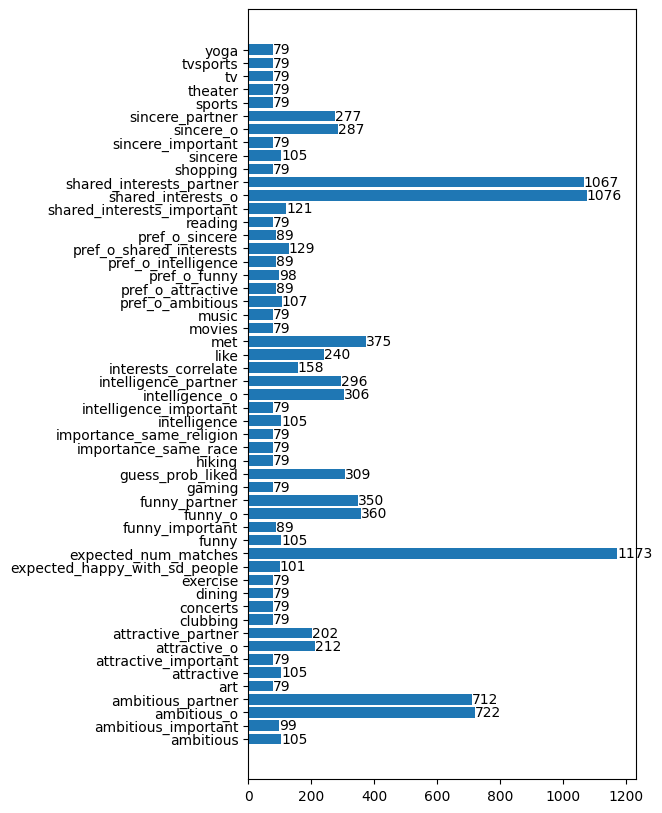

In [58]:
df_non_filled_feature: DataFrame = df[df.columns[df.count() != len(df)]]
plt.figure(figsize=(5,10))
bars = plt.barh(
    df_non_filled_feature.columns,
    width=len(df) - df_non_filled_feature.count()
)
for i, bar in enumerate(bars):
    yval = bar.get_width()
    plt.text(yval + .2, i, yval, va='center')

plt.show()

# Imputation des valeurs

In [59]:
imputers_names: list[str] = []
imputers: list[str] = []
imputers_columns: list[list[str]] = []
imputers_ignored_columns: list[str] = []

## race

Même si il n'y a pas de valeur manquante sur le jeu de donnée, par défaut on peut définir un imputer sur cette colonne pour que lors de l'inférence la valeur soit par défaut a 'Other'

'samerace' sera calculée automatiquement donc on peut l'ignorer

In [60]:
from sklearn.impute import SimpleImputer

race_imputer: SimpleImputer = SimpleImputer(strategy='constant', fill_value='Other')
race_imputer.fit(df[['race', 'race_o']])
imputers.append("SimpleImputer(strategy='constant', fill_value='Other')")
imputers_names.append('race')
imputers_columns.append(['race', 'race_o'])

imputers_ignored_columns.append('samerace')


## art, clubbing, concerts, dining, exercise, gaming, hiking, match, movies, music, reading, shopping, sports, theater, tv, tvsports, yoga

Par défaut on considère que si la valeur n'est pas défini c'est qu'il n'y a pas de pratique/intérêt sur l'activité donc la valeur sera 0

In [61]:
hobbies: list[str] = [ 'art', 'clubbing', 'concerts', 'dining', 'exercise', 'gaming', 'hiking', 'movies', 'music', 'reading', 'shopping', 'sports', 'theater', 'tv', 'tvsports', 'yoga']
hobbies_imputer: SimpleImputer = SimpleImputer(strategy='constant', fill_value=0)
hobbies_imputer.fit(df[hobbies])
imputers.append("SimpleImputer(strategy='constant', fill_value=0)")
imputers_names.append('hobbies')
imputers_columns.append(hobbies)

## met

La question 'Aviez-vous déjà rencontré votre partenaire avant ?' devrait plutot être 'Combien de fois avez vous déjà rencontré votre partenaire avant ?'

In [62]:
display(Markdown(df[['met']].custom.describe().to_markdown()))

met_imputer: SimpleImputer = SimpleImputer(strategy='most_frequent')
met_imputer.fit(df[['met']])
imputers.append("SimpleImputer(strategy='most_frequent')")
imputers_names.append('met')
imputers_columns.append(['met'])

|         |          met |
|:--------|-------------:|
| count   | 8003         |
| missing |  375         |
| mean    |    0.0498563 |
| std     |    0.282168  |
| min     |    0         |
| 25%     |    0         |
| 50%     |    0         |
| 75%     |    0         |
| max     |    8         |

## Sincere, funny, atractive, ambition, shared_interests, intelligence

In [63]:
grouped_features: list[list[str]] = [
    ['sincere', 'sincere_partner', 'sincere_o', 'pref_o_sincere', 'sincere_important'],
    ['funny', 'funny_partner', 'funny_o', 'pref_o_funny', 'funny_important'],
    ['attractive', 'attractive_partner', 'attractive_o', 'pref_o_attractive', 'attractive_important'],
    ['ambitious', 'ambitious_partner', 'ambitious_o', 'pref_o_ambitious', 'ambitious_important'],
    ['intelligence', 'intelligence_partner', 'intelligence_o', 'pref_o_intelligence', 'intelligence_important'],
    ['shared_interests_partner', 'shared_interests_o', 'pref_o_shared_interests', 'shared_interests_important']
]

display(Markdown(
f"""
{df[['sincere', 'sincere_partner', 'sincere_o', 'pref_o_sincere', 'sincere_important']].custom.describe().to_markdown()}

{df[['funny', 'funny_partner', 'funny_o', 'pref_o_funny', 'funny_important']].custom.describe().to_markdown()}

{df[['attractive', 'attractive_partner', 'attractive_o', 'pref_o_attractive', 'attractive_important']].custom.describe().to_markdown()}

{df[['ambitious', 'ambitious_partner', 'ambitious_o', 'pref_o_ambitious', 'ambitious_important']].custom.describe().to_markdown()}

{df[['intelligence', 'intelligence_partner', 'intelligence_o', 'pref_o_intelligence', 'intelligence_important']].custom.describe().to_markdown()}

{df[['shared_interests_partner', 'shared_interests_o', 'pref_o_shared_interests', 'shared_interests_important']].custom.describe().to_markdown()}
"""))


|         |    sincere |   sincere_partner |   sincere_o |   pref_o_sincere |   sincere_important |
|:--------|-----------:|------------------:|------------:|-----------------:|--------------------:|
| count   | 8273       |        8101       |  8091       |        8289      |           8299      |
| missing |  105       |         277       |   287       |          89      |             79      |
| mean    |    8.29494 |           7.17516 |     7.17526 |          17.3969 |             17.3964 |
| std     |    1.40746 |           1.74032 |     1.74058 |           7.044  |              7.0467 |
| min     |    2       |           0       |     0       |           0      |              0      |
| 25%     |    8       |           6       |     6       |          15      |             15      |
| 50%     |    8       |           7       |     7       |          18.37   |             18.18   |
| 75%     |    9       |           8       |     8       |          20      |             20      |
| max     |   10       |          10       |    10       |          60      |             60      |

|         |      funny |   funny_partner |    funny_o |   pref_o_funny |   funny_important |
|:--------|-----------:|----------------:|-----------:|---------------:|------------------:|
| count   | 8273       |       8028      | 8018       |     8280       |        8289       |
| missing |  105       |        350      |  360       |       98       |          89       |
| mean    |    8.40396 |          6.4006 |    6.4006  |       17.4597  |          17.457   |
| std     |    1.07661 |          1.9537 |    1.95408 |        6.08553 |           6.08524 |
| min     |    3       |          0      |    0       |        0       |           0       |
| 25%     |    8       |          5      |    5       |       15       |          15       |
| 50%     |    8       |          7      |    7       |       18       |          18       |
| 75%     |    9       |          8      |    8       |       20       |          20       |
| max     |   10       |         10      |   11       |       50       |          50       |

|         |   attractive |   attractive_partner |   attractive_o |   pref_o_attractive |   attractive_important |
|:--------|-------------:|---------------------:|---------------:|--------------------:|-----------------------:|
| count   |   8273       |           8176       |     8166       |           8289      |              8299      |
| missing |    105       |            202       |      212       |             89      |                79      |
| mean    |      7.08473 |              6.19    |        6.19041 |             22.4953 |                22.5146 |
| std     |      1.39578 |              1.95017 |        1.95031 |             12.5698 |                12.5877 |
| min     |      2       |              0       |        0       |              0      |                 0      |
| 25%     |      6       |              5       |        5       |             15      |                15      |
| 50%     |      7       |              6       |        6       |             20      |                20      |
| 75%     |      8       |              8       |        8       |             25      |                25      |
| max     |     10       |             10       |       10.5     |            100      |               100      |

|         |   ambitious |   ambitious_partner |   ambitious_o |   pref_o_ambitious |   ambitious_important |
|:--------|------------:|--------------------:|--------------:|-------------------:|----------------------:|
| count   |  8273       |          7666       |    7656       |         8271       |            8279       |
| missing |   105       |           712       |     722       |          107       |              99       |
| mean    |     7.57839 |             6.77752 |       6.77841 |           10.6854  |              10.6825  |
| std     |     1.77832 |             1.79405 |       1.79408 |            6.12654 |               6.12489 |
| min     |     2       |             0       |       0       |            0       |               0       |
| 25%     |     7       |             6       |       6       |            5       |               5       |
| 50%     |     8       |             7       |       7       |           10       |              10       |
| 75%     |     9       |             8       |       8       |           15       |              15       |
| max     |    10       |            10       |      10       |           53       |              53       |

|         |   intelligence |   intelligence_partner |   intelligence_o |   pref_o_intelligence |   intelligence_important |
|:--------|---------------:|-----------------------:|-----------------:|----------------------:|-------------------------:|
| count   |     8273       |             8082       |        8072      |             8289      |                8299      |
| missing |      105       |              296       |         306      |               89      |                  79      |
| mean    |        7.70446 |                7.3686  |           7.3693 |               20.2708 |                  20.2656 |
| std     |        1.56432 |                1.55045 |           1.5505 |                6.7829 |                   6.783  |
| min     |        2       |                0       |           0      |                0      |                   0      |
| 25%     |        7       |                6       |           6      |               17.39   |                  17.39   |
| 50%     |        8       |                7       |           7      |               20      |                  20      |
| 75%     |        9       |                8       |           8      |               23.81   |                  23.81   |
| max     |       10       |               10       |          10      |               50      |                  50      |

|         |   shared_interests_partner |   shared_interests_o |   pref_o_shared_interests |   shared_interests_important |
|:--------|---------------------------:|---------------------:|--------------------------:|-----------------------------:|
| count   |                 7311       |           7302       |                8249       |                   8257       |
| missing |                 1067       |           1076       |                 129       |                    121       |
| mean    |                    5.47456 |              5.47487 |                  11.8459  |                     11.8451  |
| std     |                    2.15636 |              2.15616 |                   6.36275 |                      6.36215 |
| min     |                    0       |              0       |                   0       |                      0       |
| 25%     |                    4       |              4       |                   9.52    |                      9.52    |
| 50%     |                    6       |              6       |                  10.64    |                     10.64    |
| 75%     |                    7       |              7       |                  16       |                     16       |
| max     |                   10       |             10       |                  30       |                     30       |


In [64]:
criterion = [
    'sincere', 'sincere_partner', 'sincere_o', 'pref_o_sincere', 'sincere_important',
    'funny', 'funny_partner', 'funny_o', 'pref_o_funny', 'funny_important',
    'attractive', 'attractive_partner', 'attractive_o', 'pref_o_attractive', 'attractive_important',
    'ambitious', 'ambitious_partner', 'ambitious_o', 'pref_o_ambitious', 'ambitious_important',
    'intelligence', 'intelligence_partner', 'intelligence_o', 'pref_o_intelligence', 'intelligence_important',
    'shared_interests_partner', 'shared_interests_o', 'pref_o_shared_interests', 'shared_interests_important'
]

criterion_imputer = SimpleImputer(strategy="mean")
criterion_imputer.fit(df[criterion])
imputers.append("SimpleImputer(strategy='mean')")
imputers_names.append('criterion')
imputers_columns.append(criterion)

## Age

Les colonnes age, age_o ont été complété dans le DataFrame directement, elles ne seront donc pas imputés car la colonne age sera obligatoirement renseigné par l'utilisateur à l'inférence du modèle

In [65]:
imputers_ignored_columns.append('age')
imputers_ignored_columns.append('age_o')
imputers_ignored_columns.append('d_age')


## Gender

Le genre est entièrement renseigné, il sera obligatoire pour l'inférence

In [66]:
imputers_ignored_columns.append('gender')

# importance_same_race, importance_same_religion

In [67]:
df_same_race_describe: DataFrame = df[['importance_same_race', 'importance_same_religion']].custom.describe()

display(Markdown(
f"""
{df_same_race_describe.to_markdown()}

On remplace la valeur d'importance pour ces 2 caractéristique par la valeur moyenne
"""))

importance_race_religion_imputer = SimpleImputer(strategy="mean")
importance_race_religion_imputer.fit(df[['importance_same_race', 'importance_same_religion']])
imputers.append("SimpleImputer(strategy='mean')")
imputers_names.append('importance_race_religion')
imputers_columns.append(['importance_same_race', 'importance_same_religion'])




|         |   importance_same_race |   importance_same_religion |
|:--------|-----------------------:|---------------------------:|
| count   |             8299       |                 8299       |
| missing |               79       |                   79       |
| mean    |                3.78479 |                    3.65164 |
| std     |                2.84571 |                    2.80524 |
| min     |                0       |                    1       |
| 25%     |                1       |                    1       |
| 50%     |                3       |                    3       |
| 75%     |                6       |                    6       |
| max     |               10       |                   10       |

On remplace la valeur d'importance pour ces 2 caractéristique par la valeur moyenne


## decision, decision_o, match

La colonne match pourrait etre retirer, et on pourrait chercher a prédire decision_o ou decision

In [68]:
display(Markdown(
f"""
{df[['decision', 'decision_o', 'match']].custom.describe().to_markdown()}

Il ne manque pas de valeurs pour ces colonnes et si on regarde en détail on a bien {len(df[(df['decision'] == 1) & (df['decision_o'] == 1)])} valeur pour 'decision' et 'decision_o' a 1 et {len(df[df['match'] == 1])} valeurs de match a 1

Le profil sera tester 2 fois
- Quelle est la probabilité qu'un profil soit compatible avec moi ('decision_o' == 1)
- Quelle est la probabilité que je soit compatible avec un autre profil ('decision' == 1)
"""))

imputers_ignored_columns.append('decision')
imputers_ignored_columns.append('decision_o')
imputers_ignored_columns.append('match')


|         |    decision |   decision_o |       match |
|:--------|------------:|-------------:|------------:|
| count   | 8378        |  8378        | 8378        |
| missing |    0        |     0        |    0        |
| mean    |    0.419909 |     0.419551 |    0.164717 |
| std     |    0.493573 |     0.493515 |    0.370947 |
| min     |    0        |     0        |    0        |
| 25%     |    0        |     0        |    0        |
| 50%     |    0        |     0        |    0        |
| 75%     |    1        |     1        |    0        |
| max     |    1        |     1        |    1        |

Il ne manque pas de valeurs pour ces colonnes et si on regarde en détail on a bien 1380 valeur pour 'decision' et 'decision_o' a 1 et 1380 valeurs de match a 1

Le profil sera tester 2 fois
- Quelle est la probabilité qu'un profil soit compatible avec moi ('decision_o' == 1)
- Quelle est la probabilité que je soit compatible avec un autre profil ('decision' == 1)


In [69]:
df[['expected_happy_with_sd_people', 'expected_num_matches', 'guess_prob_liked', 'like', 'interests_correlate']].custom.describe()

remains_imputer: SimpleImputer = SimpleImputer(strategy='mean')
remains_imputer.fit(df[['expected_happy_with_sd_people', 'expected_num_matches', 'guess_prob_liked', 'like', 'interests_correlate']])
imputers.append("SimpleImputer(strategy='mean')")
imputers_names.append('remains')
imputers_columns.append(['expected_happy_with_sd_people', 'expected_num_matches', 'guess_prob_liked', 'like', 'interests_correlate'])

In [70]:
# prendre la différences entre les colonnes de la variable columns et imputers_columns
imputers_columns_flatten = [col for sublist in imputers_columns for col in sublist]
print(f"Il reste {len([c for c in columns if c not in [*imputers_columns_flatten, *imputers_ignored_columns]])} colonne a traiter")

Il reste 0 colonne a traiter


In [78]:
transformers_code_line: list[str] = []

for i, imputer in enumerate(imputers):
    transformers_code_line.append(f"('{imputers_names[i]}', {imputer}, {imputers_columns[i]}),")

print(f"""\
transformer = ColumnTransformer(
    transformers=[
{TAB+TAB}{f"{NL+TAB+TAB}".join(transformers_code_line)}
    ],
    remainder='passthrough'
)
""")

transformer = ColumnTransformer(
    transformers=[
		('race', SimpleImputer(strategy='constant', fill_value='Other'), ['race', 'race_o']),
		('hobbies', SimpleImputer(strategy='constant', fill_value=0), ['art', 'clubbing', 'concerts', 'dining', 'exercise', 'gaming', 'hiking', 'movies', 'music', 'reading', 'shopping', 'sports', 'theater', 'tv', 'tvsports', 'yoga']),
		('met', SimpleImputer(strategy='most_frequent'), ['met']),
		('criterion', SimpleImputer(strategy='mean'), ['sincere', 'sincere_partner', 'sincere_o', 'pref_o_sincere', 'sincere_important', 'funny', 'funny_partner', 'funny_o', 'pref_o_funny', 'funny_important', 'attractive', 'attractive_partner', 'attractive_o', 'pref_o_attractive', 'attractive_important', 'ambitious', 'ambitious_partner', 'ambitious_o', 'pref_o_ambitious', 'ambitious_important', 'intelligence', 'intelligence_partner', 'intelligence_o', 'pref_o_intelligence', 'intelligence_important', 'shared_interests_partner', 'shared_interests_o', 'pref_o_shared_intere